In [361]:
#0.Importing required packages 
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sys
import traceback
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import stattools
from scipy import signal
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.pipelines.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from itertools import product
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5
import pandas as pd
import numpy as np
from datetime import datetime
from fedot.core.data.multi_modal import MultiModalData
# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5
import statsmodels.tsa.api as smt

## Step 01: Preparing Data

In [368]:
#1.Reading Data 
energydata = pd.read_csv("./energydata_complete.csv")
#2.Creating subsamples 
#2.1.Choosing colomns .. Target is T2,Tout
sample_energydata=energydata[[ 'date','T2', 'T5','T6','T_out']]
df_sample_colomn_energydata = pd.DataFrame(sample_energydata)

In [369]:
#timestamps to daily
df_sample_colomn_energydata['date']=pd.to_datetime(df_sample_colomn_energydata['date'], infer_datetime_format=True )
df_sample_colomn_energydata['date']=df_sample_colomn_energydata['date'].dt.round('1d')  

In [444]:
# Aggregation data
df_daily=df_sample_colomn_energydata.groupby('date', as_index=False).agg({"T2": "median","T5": "median","T6": "median","T_out": "median" }) # median
df_daily=df_daily.sort_values('date')
df_daily.index=pd.date_range(freq="m",start=df_daily["date"][0],periods=len(df_daily['date']))

### trying to delete the trend in the data

In [ ]:
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [ ]:
#trend subtraction using differences
print(df_sample_colomn_energydata['T2'])
diff = difference(dataset=df_sample_colomn_energydata['T2'], interval=1)
plt.plot(diff)
plt.show()
df_sample_colomn_energydata['T2']=df_sample_colomn_energydata['T2']-diff
# stationarity('T2')
print(df_sample_colomn_energydata['T2'])


In [ ]:
print(diff)

In [ ]:
print(df_daily)
diff = difference(dataset=df_daily['T2'], interval=1)
v=df_daily['T2'].add(diff)
#print(df_daily)
df_daily.drop('T2',axis=1)
v.name='new T2'
df_daily['new T2']=(v)
print(df_daily)

## Step 02: Stationarity of a process (for mathematical expectation and variance)

In [442]:
def stationarity(col_name,df):
    # #### diff = difference(dataset=df_daily_T2['T2'], interval=1)
    # #### df_daily_T2['T2']=df_daily_T2['T2']-diff
    #plotting
    plt.figure(figsize=(8, 6))
    plt.plot(df['date'],df[col_name])
    plt.xticks(rotation=45)
    plt.xlabel(u'Date', fontsize = 20)
    plt.ylabel(u'Mean', fontsize = 20)
    plt.title(col_name, fontsize = 20)
    # Testing , lower p-value --> more stationary
    result = smt.stattools.adfuller(df[col_name])
    print(col_name+': Augmented Dickey-Fuller test:\nStatistic value = %5f\np-value = %5f' % (result[0], result[1]))
    # df.index=pd.date_range(freq="m",start=df["date"][0],periods=len(df["date"]))
    #moving average
    result = seasonal_decompose((df[col_name]), model='additive')
    fig=result.plot()
    fig.set_figheight(6)
    fig.set_figwidth(14)
    plt.show()
    return df

### T2

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1418: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


T2: Augmented Dickey-Fuller test:
Statistic value = -1.948464
p-value = 0.309617


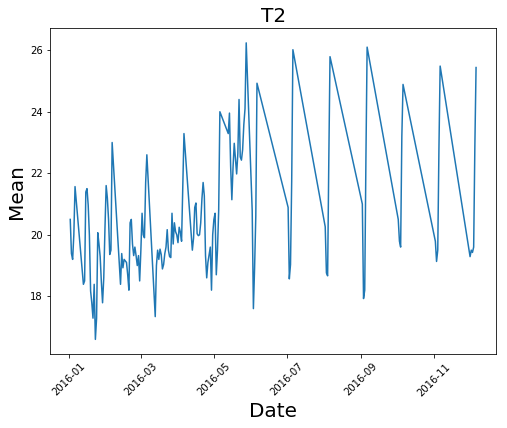

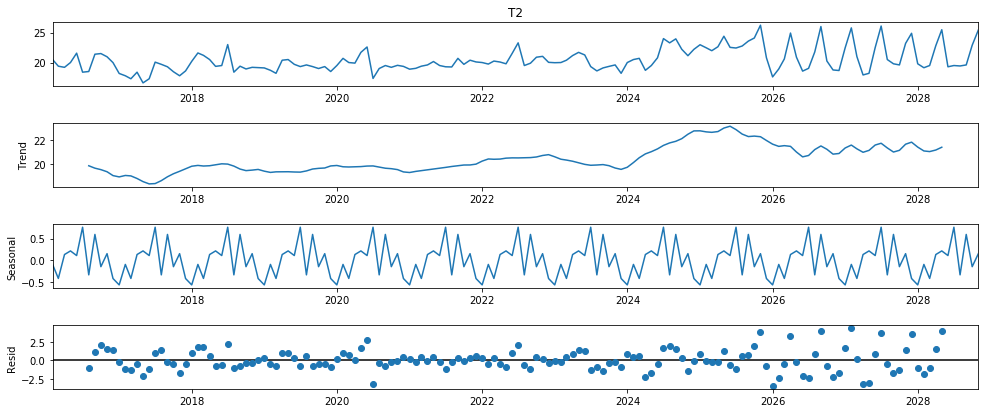

In [365]:
df_daily_T2=stationarity('T2',df_daily)

In [ ]:
result = smt.stattools.adfuller((df_sample_colomn_energydata['T2']))
print('Augmented Dickey-Fuller test:\nStatistic value = %5f\np-value = %5f' % (result[0], result[1]))

### T2 for half of the data

In [445]:
half_data=df_daily[df_daily.date> datetime(2016,6,1)] # after the result of T2
# half_data=half_data[df_daily.date< datetime(2016,9,1)] 

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1418: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


T2: Augmented Dickey-Fuller test:
Statistic value = -7.218217
p-value = 0.000000


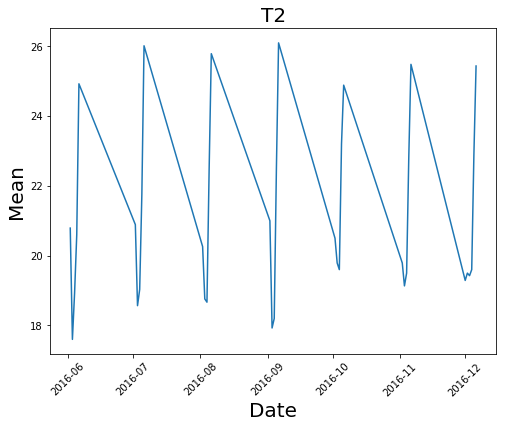

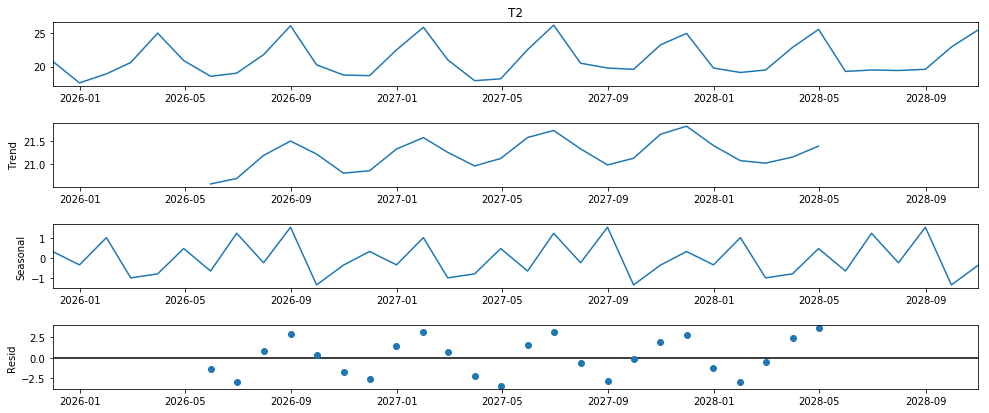

In [448]:
df_daily_T2_half=stationarity('T2',half_data)

### T5

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1418: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


T5: Augmented Dickey-Fuller test:
Statistic value = -1.825630
p-value = 0.367813


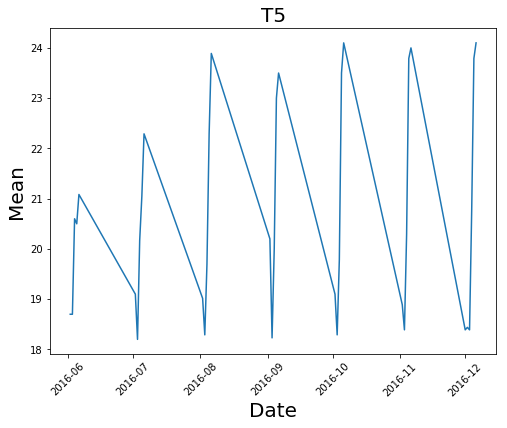

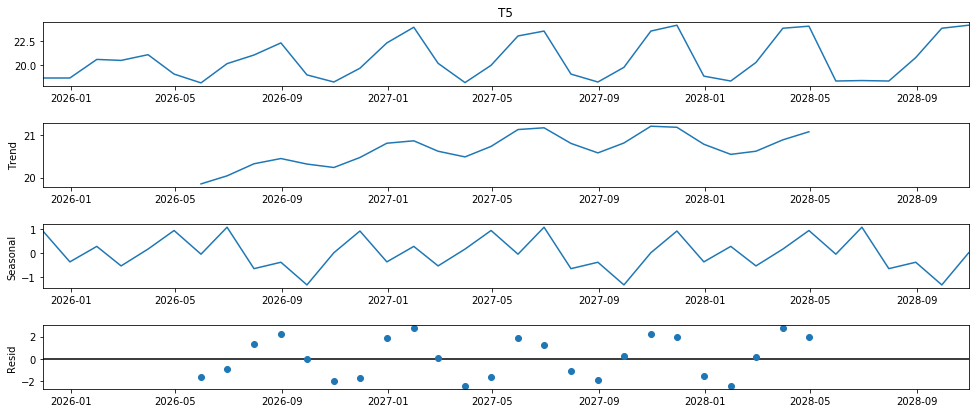

In [449]:
df_daily_T5=stationarity('T5',half_data) 

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1418: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


T6: Augmented Dickey-Fuller test:
Statistic value = -1.340223
p-value = 0.610575


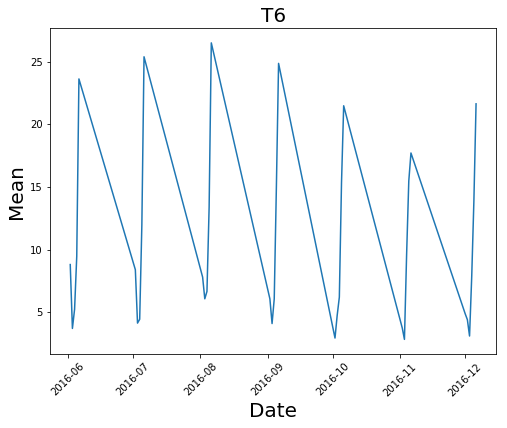

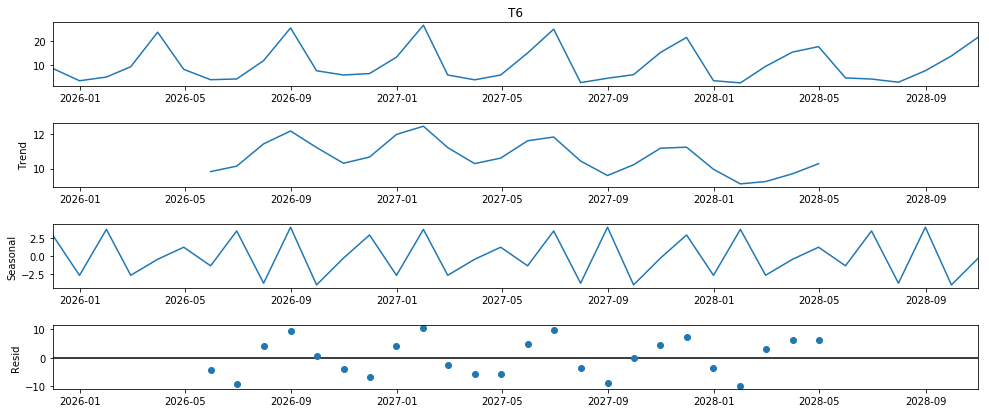

In [450]:
df_daily_T6=stationarity("T6",half_data)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1418: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


T_out: Augmented Dickey-Fuller test:
Statistic value = -1.427776
p-value = 0.568890


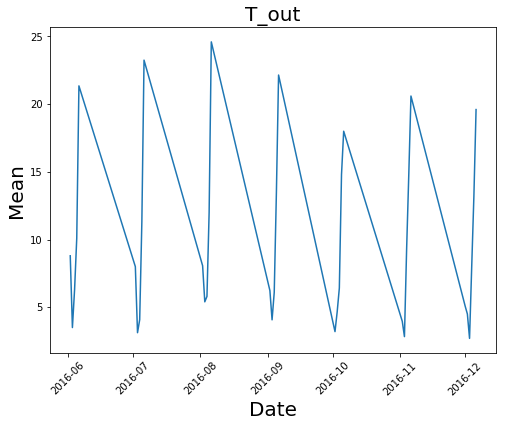

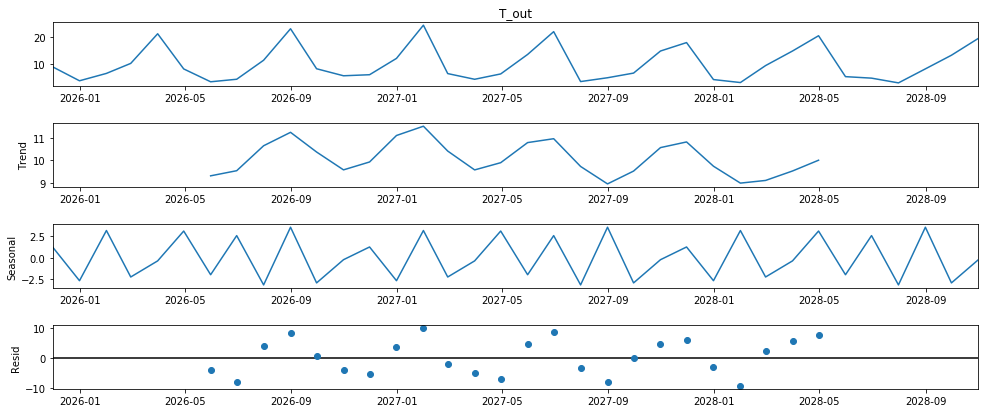

In [451]:
df_daily_Tout=stationarity("T_out",half_data)

## Step 03: Analyze covariance or correlation function for chosen target variables and mutual correlation functions among predictors and targets

### Covariance for Targets : T2 , T_out

Text(0.5, 1.0, 'T2')

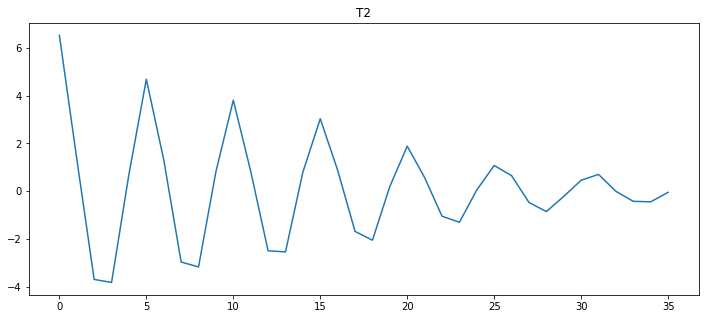

In [452]:
plt.plot(stattools.acovf(half_data['T2'],fft=False)) #autocovariance without window
plt.title("T2")

Text(0.5, 1.0, 'Tout')

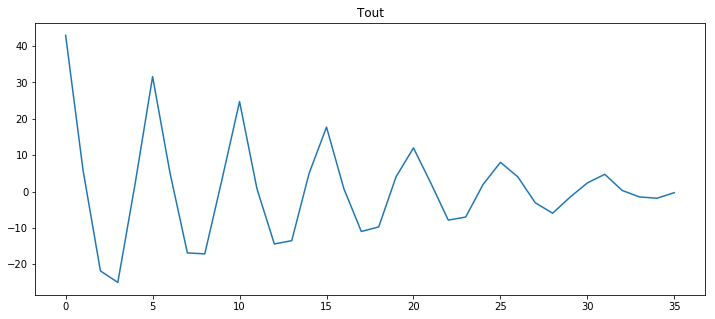

In [453]:
plt.plot(stattools.acovf(half_data['T_out'],fft=False)) #autocovariance without window
plt.title("Tout")

### Mutual correlation functions among predictors and targets

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1418: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


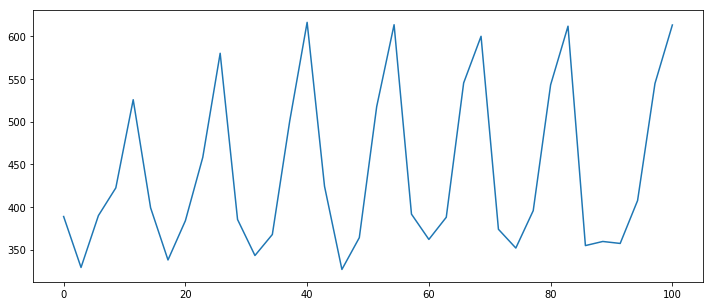

In [454]:
x=np.linspace(0,100,36)
plt.plot(x, half_data['T2']*half_data['T5'])

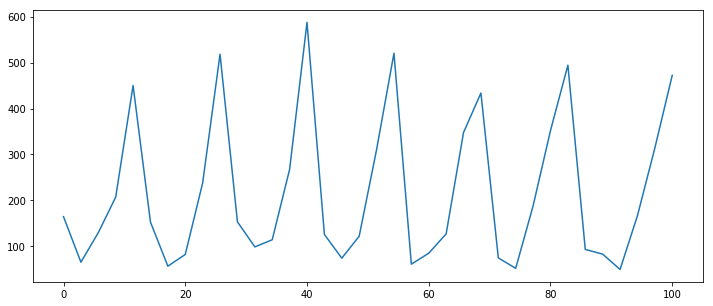

In [455]:
x=np.linspace(0,100,36)
plt.plot(x, half_data['T_out']*half_data['T5'])

In [456]:
half_data.corr()

,T2,T5,T6,T_out
T2,1.000000,0.846942,0.949102,0.955030
T5,0.846942,1.000000,0.846242,0.859154
T6,0.949102,0.846242,1.000000,0.990716
T_out,0.955030,0.859154,0.990716,1.000000


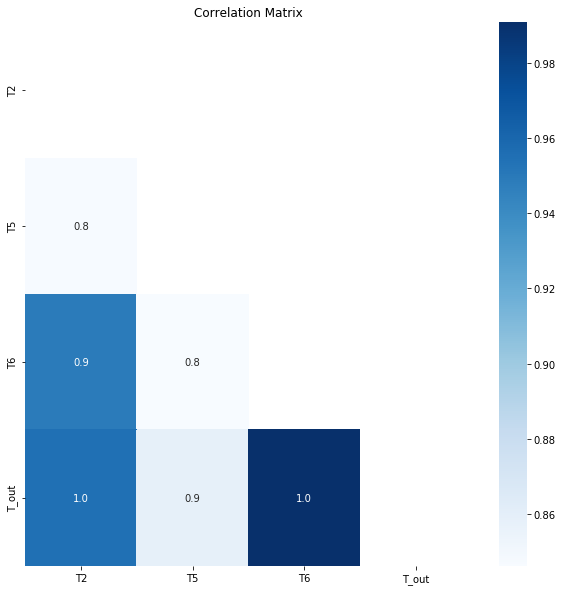

In [457]:
#Pair correlation coefficients, Correlation Matrix
fig, ax = plt.subplots(figsize=(10,10))
corr = half_data[half_data.columns[1:]].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True,  fmt='.1f',ax=ax, cmap = 'Blues')
plt.title('Correlation Matrix')
plt.show()

## Step 04: Filter high frequencies (noise) with chosen 2 filters for target variables

### T2 Filtering

In [458]:
# Data preperation
# Convert into numpy array first
time_series=np.array(half_data["T2"])
#FEDOT data preparation
# Define task - time series forecasting
# and forecast horizon 
task=Task (TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=25))
input_data = InputData(idx=np.arange(0, len(time_series)),
features=time_series, target=time_series,
task=task, data_type=DataTypesEnum.ts)

#### T2 Rolling Mean Filtering

In [459]:
# Rolling mean window smoothing
def Rolling_T2(window_size):
    smoothing_node = PrimaryNode('smoothing')
    smoothing_node.custom_params = {'window_size': window_size}
    def node_fit_predict(node, input_data):
        """ Fit node and make prediction """
        node.fit(input_data)
        smoothed_output = node.predict(input_data)
        return smoothed_output
    smoothed_output = node_fit_predict(smoothing_node, input_data)
    plt.plot(input_data.idx, input_data.target, label='Source time series')
    plt.plot(smoothed_output.idx, smoothed_output.predict, label='Smoothed by 5 elements', linewidth=3)
    plt.legend()
    plt.show()
    return smoothed_output

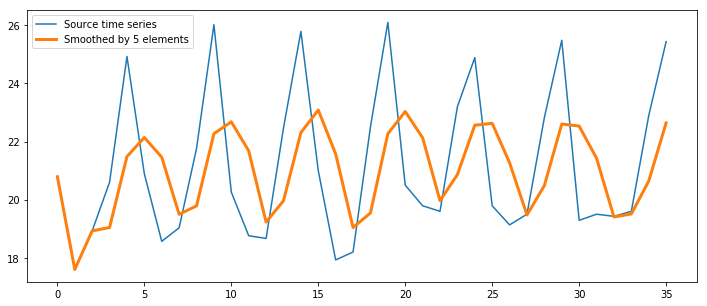

In [460]:
smoothed_output=Rolling_T2(3)

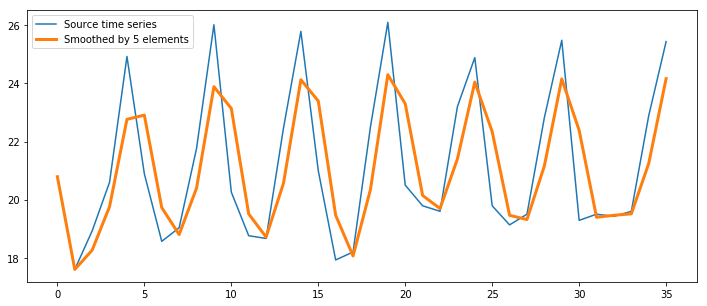

In [461]:
Rsmoothed_output_2=Rolling_T2(2)

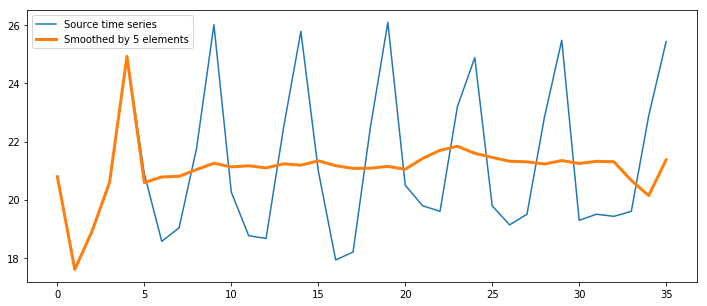

In [462]:
smoothed_output_3=Rolling_T2(5)

#### T2 Gaussian Filter - compare results - summary plots

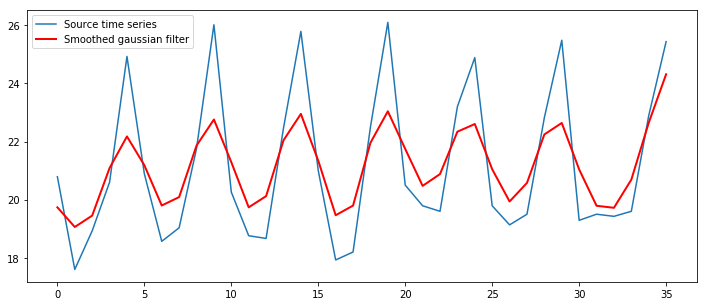

In [463]:
gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 0.8}
smoothed_gaussian = node_fit_predict(gaussian_node, input_data)
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()
plt.show()

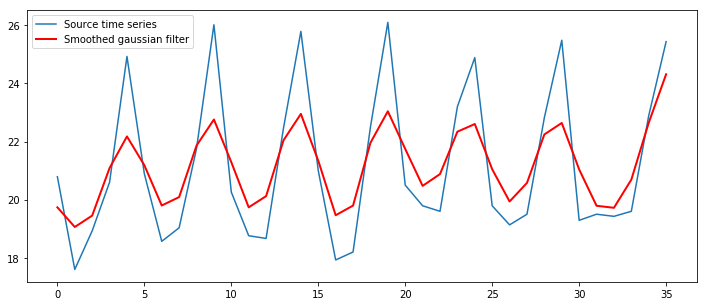

In [464]:
gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 0.9}
smoothed_gaussian_2 = node_fit_predict(gaussian_node, input_data)
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_gaussian_2.idx, smoothed_gaussian_2.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()
plt.show()

#### T2 both filters

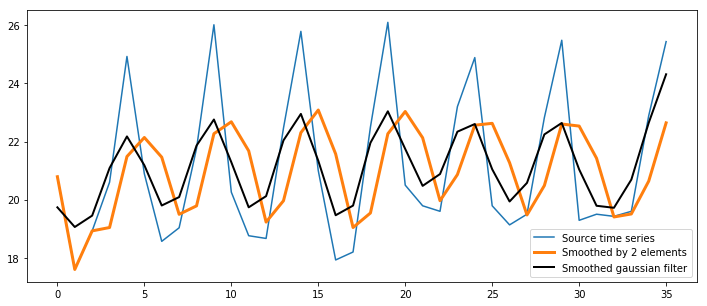

In [465]:
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_output.idx, smoothed_output.predict, label='Smoothed by 2 elements', linewidth=3)
plt.plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='black')
plt.legend()
plt.show()

### T_out Filtering

In [466]:
# Data preperation
# Convert into numpy array first
time_series_out=np.array(df_daily_Tout["T_out"])
#FEDOT data preparation
# Define task - time series forecasting
# and forecast horizon 
task=Task (TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=25))
input_data_out = InputData(idx=np.arange(0, len(time_series_out)),
features=time_series_out, target=time_series_out,
task=task, data_type=DataTypesEnum.ts)

#### T out: Rolling mean

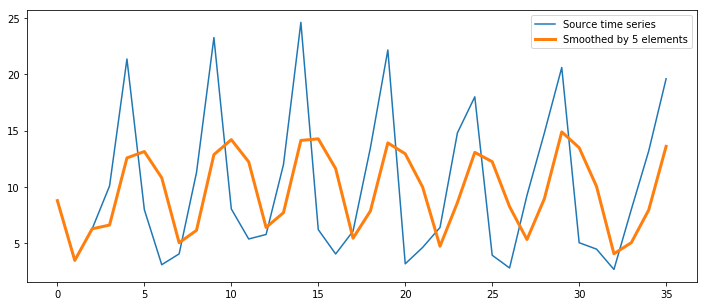

In [467]:
# Rolling mean window smoothing
smoothing_node_out = PrimaryNode('smoothing')
smoothing_node_out.custom_params = {'window_size': 3}
def node_fit_predict(node, input_data_out):
    """ Fit node and make prediction """
    node.fit(input_data_out)
    smoothed_output = node.predict(input_data_out)
    return smoothed_output
smoothed_output_out = node_fit_predict(smoothing_node_out, input_data_out)
plt.plot(input_data_out.idx, input_data_out.target, label='Source time series')
plt.plot(smoothed_output_out.idx, smoothed_output_out.predict, label='Smoothed by 5 elements', linewidth=3)
plt.legend()
plt.show()

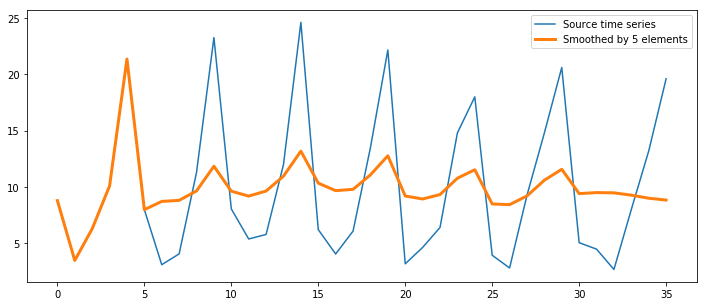

In [468]:
# Rolling mean window smoothing
smoothing_node_out = PrimaryNode('smoothing')
smoothing_node_out.custom_params = {'window_size': 6}
def node_fit_predict(node, input_data_out):
    """ Fit node and make prediction """
    node.fit(input_data_out)
    smoothed_output = node.predict(input_data_out)
    return smoothed_output
smoothed_output_out_1 = node_fit_predict(smoothing_node_out, input_data_out)
plt.plot(input_data_out.idx, input_data_out.target, label='Source time series')
plt.plot(smoothed_output_out_1.idx, smoothed_output_out_1.predict, label='Smoothed by 5 elements', linewidth=3)
plt.legend()
plt.show()

#### Tout: Gaussian filter

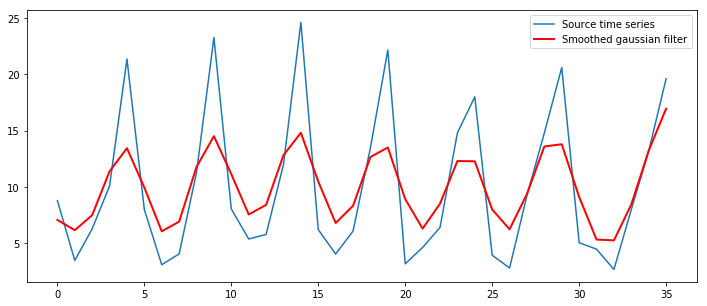

In [469]:
gaussian_node_out = PrimaryNode('gaussian_filter') 
gaussian_node_out.custom_params = {'sigma': 0.9}
smoothed_gaussian_out_1 = node_fit_predict(gaussian_node_out, input_data_out)
plt.plot(input_data_out.idx, input_data_out.target, label='Source time series')
plt.plot(smoothed_gaussian_out_1.idx, smoothed_gaussian_out_1.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()
plt.show()

#### T_out : both filters

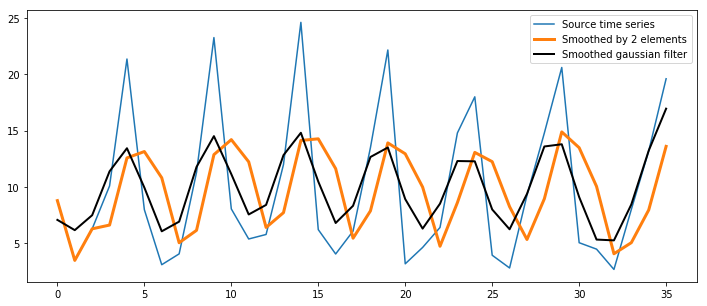

In [470]:
plt.plot(input_data_out.idx, input_data_out.target, label='Source time series')
plt.plot(smoothed_output_out.idx, smoothed_output_out.predict, label='Smoothed by 2 elements', linewidth=3)
plt.plot(smoothed_gaussian_out_1.idx, smoothed_gaussian_out_1.predict, label='Smoothed gaussian filter', linewidth=2, c='black')
plt.legend()
plt.show()

## Step 05 : Spectral density function with and without filtering
To analyze results after filtering

In [476]:
def Spec_Den_Fun(data,variable,name):
    window_size = 20
    blackman = signal.blackman(M=window_size)
    bartlett = signal.hanning(M=window_size)
    print(len(data))
    f, Pxx_den = signal.welch(variable, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
    f_window, Pxx_den_window = signal.welch(variable, fs=1, window = blackman, nfft = 1000, scaling='spectrum')
    f_window_bart, Pxx_den_window_bart = signal.welch(variable, fs=1, window = bartlett, nfft = 1000, scaling='spectrum')
    # plt.plot(f, Pxx_den, linewidth=4)
    plt.plot(f_window, Pxx_den_window)
    # plt.plot(f_window_bart, Pxx_den_window_bart)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.xlim((0,0.16))
    plt.title("Spectual Density Function "+ name)
    plt.show()

#### T2

36


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  after removing the cwd from sys.path.


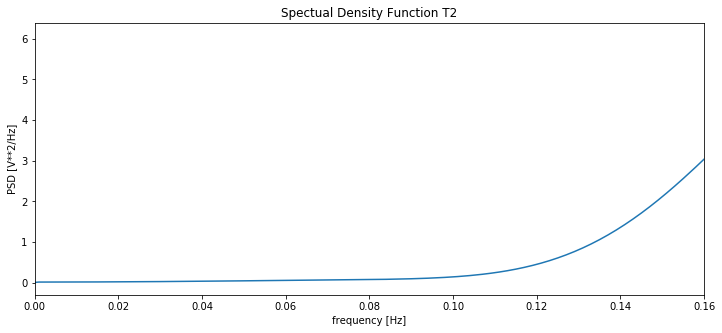

In [477]:
## Spectral density function T2 without filtering
Spec_Den_Fun(half_data,half_data["T2"],'T2')

36


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  after removing the cwd from sys.path.


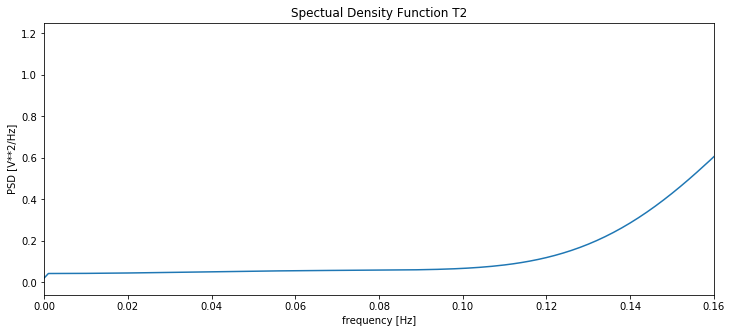

In [478]:
## Spectral density function T2 without filtering
Spec_Den_Fun(smoothed_gaussian.predict,smoothed_gaussian.predict,'T2')

#### T_out

36


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  after removing the cwd from sys.path.


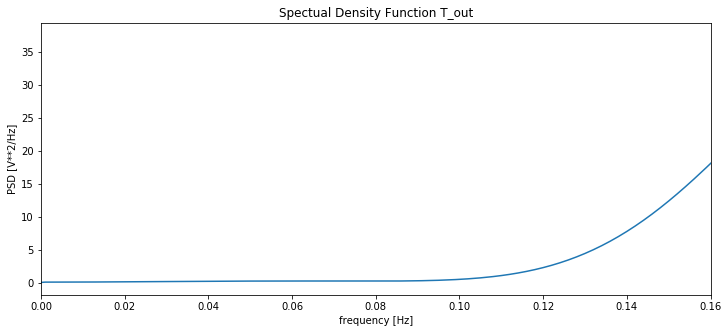

In [479]:
## Spectral density function Tout without filtering
Spec_Den_Fun(half_data,half_data["T_out"],'T_out')

36


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  after removing the cwd from sys.path.


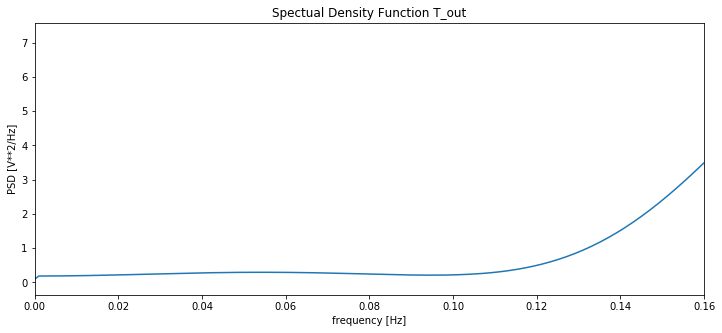

In [480]:
## Spectral density function Tout with filtering
Spec_Den_Fun(smoothed_gaussian_out.predict,smoothed_gaussian_out.predict,'T_out')

## Step 06: Built auto-regression model filtered and non-filtered data.
To analyze residual error and to define appropriate order of model.


#### T2 not filttered AR model
is it okay not to transform data before fitting to a model ?

In [498]:
# Convert into numpy array first
time_series_reg = np.array(half_data['T2'])
(time_series_reg).reshape(36,1)
# Define task - time series forecasting
# and forecast horizon 
task_reg = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=36))

input_data_reg = InputData(idx=np.arange(0, len(time_series_reg)),
                       features=time_series_reg, target=time_series_reg,
                       task=task_reg, data_type=DataTypesEnum.ts)


In [497]:
(time_series_reg).reshape(36,1)

array([[20.79      ],
       [17.6       ],
       [18.92666667],
       [20.6       ],
       [24.92666666],
       [20.89      ],
       [18.56666667],
       [19.03333333],
       [21.76      ],
       [26.01666667],
       [20.26      ],
       [18.76      ],
       [18.66666667],
       [22.46333333],
       [25.79      ],
       [21.        ],
       [17.92666667],
       [18.2       ],
       [22.5       ],
       [26.1       ],
       [20.5       ],
       [19.79      ],
       [19.6       ],
       [23.2       ],
       [24.88785714],
       [19.79      ],
       [19.13333333],
       [19.5       ],
       [22.82333333],
       [25.48428571],
       [19.29      ],
       [19.5       ],
       [19.42666667],
       [19.6       ],
       [22.89      ],
       [25.43714286]])

In [499]:
train, test = train_test_data_setup(input_data_reg)

In [500]:
train.features


array([], dtype=float64)

In [483]:
pipeline = Pipeline(PrimaryNode('ar'))
pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                        loss_params=None, input_data=train,
                                        iterations=500, timeout=5,
                                        cv_folds=2, validation_blocks=1)

Start pipeline tuning


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [414]:
fitted_vals = pipeline.fit(train)
forecast = pipeline.predict(test)

plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='AR forecast')
plt.grid()
plt.legend()
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

#### T2 not filttered SARIMA and AIC model
need validation?

In [415]:
### other way
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print (u"Models to analyse by AIC:", len(parameters_list))

Models to analyse by AIC: 72


In [416]:
results = []
best_aic = float("inf")

for param in parameters_list:
    #try except for the case of wrong parameters
    try:
        model =sm.tsa.statespace.SARIMAX(np.array(half_data['T2']), order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #print wrong parameters and go on
    # AIC criteria:
    except BaseException as ex:
        # Get current system exception
        ex_type, ex_value, ex_traceback = sys.exc_info()

        # Extract unformatter stack traces as tuples
        trace_back = traceback.extract_tb(ex_traceback)

        # Format stacktrace
        stack_trace = list()

        for trace in trace_back:
            stack_trace.append("File : %s , Line : %d, Func.Name : %s, Message : %s" % (trace[0], trace[1], trace[2], trace[3]))

        print("Exception type : %s " % ex_type.__name__)
        print("Exception message : %s" %ex_value)
        print("Stack trace : %s" %stack_trace)
    aic = model.aic
    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [417]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
52  (4, 2, 0, 0)  105.814762
56  (4, 4, 0, 0)  106.092828
54  (4, 3, 0, 0)  106.654608
68  (5, 4, 0, 0)  107.234024
28  (2, 2, 0, 0)  107.288489


In [418]:
print(best_model.summary())


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   36
Model:             SARIMAX(4, 1, 2)x(0, 1, [], 12)   Log Likelihood                 -45.907
Date:                             Fri, 26 Nov 2021   AIC                            105.815
Time:                                     06:49:53   BIC                            113.763
Sample:                                          0   HQIC                           107.814
                                              - 36                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7503      0.200     -3.745      0.000      -1.143      -0.358
ar.L2         -0.8482      

In [419]:
type(half_data["T2"][35])

KeyError: 35

In [ ]:
plt.plot(best_model.fittedvalues)
half_data['date']=pd.to_datetime(half_data['date'], infer_datetime_format=True )
plt.plot(half_data['T2'],color='black')

#### T2 filttered

## Step 07: Build model in a form of linear dynamical system, using chosen predictors.
To analyze residual error and to define appropriate order of model.

### T2 based on RH2 and T6

In [356]:
# Data preprocessing for FEDOT
def wrap_into_input(forecast_length, feature_time_series, target_time_series):
    """ Convert data for FEDOT framework """
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))
    
    input_data = InputData(idx=np.arange(0, len(target_time_series)),
                           features=feature_time_series, target=target_time_series,
                           task=task, data_type=DataTypesEnum.ts)
    
    return input_data
forecast_length = 200
ts_1 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=np.array(half_data['T2']),
                       target_time_series=np.array(half_data['T6']))

ts_2 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=np.array(half_data['T2']),
                       target_time_series=np.array(half_data['T5']))

dataset = MultiModalData({
    'data_source_ts/Hsig': ts_1,
    'data_source_ts/RTpeak': ts_2
})

In [357]:
train, test = train_test_data_setup(dataset)

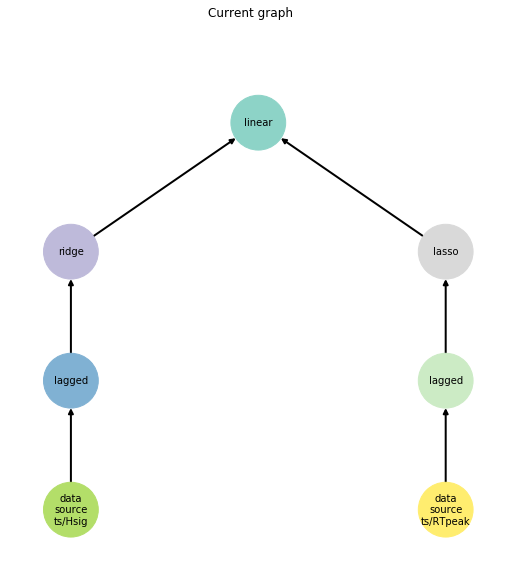

In [358]:
def create_multisource_pipeline():
    """ Generate pipeline with several data sources """
    node_source_1 = PrimaryNode('data_source_ts/Hsig')
    node_source_2 = PrimaryNode('data_source_ts/RTpeak')

    node_lagged_1 = SecondaryNode('lagged', nodes_from=[node_source_1])
    node_lagged_1.custom_params = {'window_size': 150}
    node_lagged_2 = SecondaryNode('lagged', nodes_from=[node_source_2])
      
    node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged_1])
    node_lasso = SecondaryNode('lasso', nodes_from=[node_lagged_2])
    
    node_final = SecondaryNode('linear', nodes_from=[node_ridge, node_lasso])
    pipeline = Pipeline(node_final)
    return pipeline

pipeline = create_multisource_pipeline()
pipeline.show()

In [359]:
pipeline.fit(train)
forecast = pipeline.predict(test)

train_length = len(half_data['T2']) - forecast_length

plt.plot(half_data['T2'], label='Actual time series')
plt.plot(np.arange(train_length, train_length + forecast_length), 
         np.ravel(forecast.predict), label='Forecast')
plt.xlim(train_length - 100, len(half_data['T2']) + 10)
plt.legend()
plt.grid()
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

### T_out based on T5 and T6

In [426]:
Tout_ts_1 = wrap_into_input(forecast_length=forecast_length, 
                       target_time_series=np.array(half_data['T_out']),
                       feature_time_series=np.array(half_data['T6']))

T6outts_2 = wrap_into_input(forecast_length=forecast_length, 
                       target_time_series=np.array(half_data['T_out']),
                       feature_time_series=np.array(half_data['T5']))

dataset_out = MultiModalData({
    'data_source_ts/Hsig': ts_1,
    'data_source_ts/RTpeak': ts_2
})

In [427]:
train_out, test_out = train_test_data_setup(dataset_out)

In [428]:
pipeline_out = create_multisource_pipeline()

In [430]:
forecast_length_out=200
pipeline_out.fit(train_out)
forecast_out = pipeline.predict(test_out)

train_length_out = len(half_data['T_out']) - forecast_length_out

plt.plot(half_data['T_out'], label='Actual time series')
plt.plot(np.arange(train_length_out, train_length_out + forecast_length_out), 
         np.ravel(forecast_out.predict), label='Forecast')
plt.xlim(train_length_out - 100, len(half_data['T_out']) + 10)
plt.legend()
plt.grid()
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.